In [435]:
# Make Jupyter wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

![XKCD of Flying!](https://imgs.xkcd.com/comics/python.png)

# Scrape the Web

In [ ]:
from selenium import webdriver
import html5lib, lxml
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
import time
import os

#### Construct URL(s) and log in

In [ ]:
# %matplotlib

state = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL",
         "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME",
         "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
         "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI",
         "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
gender = ['Boys', 'Girls']
year = ['2000','2001','2002','2003','2004','2005','2006','2007',
        '2008','2009','2010','2011','2012','2013','2014','2015','2016']
page = ['1','2','3','4','5','6','7','8','9','10',
        '11','12','13','14','15','16','17','18','19','20']

login_url = 'https://accounts.milesplit.com/login?'
url = "http://" + state[0] + ".milesplit.com/rankings/events/" + "high-school-" + gender[0] + "/cross-country/5000m?year=" + year[0] + "&page=" + page[0]

init_url = login_url + 'next=' + url
driver = webdriver.Chrome()                   # need to use Selenium webdriver because login page is dynamically generated
driver.get(init_url)

## Log in
username = driver.find_element_by_name("username")
password = driver.find_element_by_name("password")
username.send_keys("XXXXXX")
password.send_keys("XXXXXX")
time.sleep(3)                                  # explicit wait, until javascript finishes and button is clickable
driver.find_element_by_xpath("//a[contains(@class, 'btn-continue')]").click()
time.sleep(3)

#### Harvest and parse the data, while ooping through each URL

In [ ]:
## Initialize list of dataframes
dfs = []

## Parse HTML table on passed page into a Pandas dataframe, return dataframe
def page_df(yr, st, ge):
        df_page = pd.read_html(content)[0]  # index chooses the first (only) dataframe of a list of dataframes
        df_page['Year'] = yr            # append Year column
        df_page['State'] = st           # append State column
        df_page['Gender'] = ge          # append Gender column
        return (df_page)
    
## Loop over all desired URLs
for ge in gender:
    for st in state:
        for yr in year:
            for pg in page:
                url = "http://" + st + ".milesplit.com/rankings/events/" + "high-school-" + ge + "/cross-country/5000m?year=" + yr + "&page=" + pg
                driver.get(url)
                time.sleep(1)                     # increase this to pretend I'm not a robot
                content = driver.page_source      # this returns the raw HTML
                if "<table" not in content: 
                    df_page = []
                    table_flag = 0
#                     print "No results this year."
                    break
                else: 
                    table_flag = 1
                    if "pagination" not in content:
#                         print "Last page of results for this year"
                        dfs.append(page_df(yr, st, ge))
                        break
                    else:
                        teststring = "Page " + str(pg) + " of "                                        # these 3 lines are determining whether there are 20 pages of data,
                        page_of = content.find(teststring)                                             #  because if there isn't, passing a page number one greater than the
                        num_pages = int(content[page_of+len(teststring):page_of+len(teststring)+2])    #   number of pages returns ALL the records. Its a HUGE shortcut!
#                         print num_pages
                        if num_pages < 20:
#                             print "Woohoo! Shortcut.."
                            pg = str(num_pages + 1)    # request page one greater than listed...
                            url = "http://" + st + ".milesplit.com/rankings/events/" + "high-school-" + ge + "/cross-country/5000m?year=" + yr + "&page=" + str(pg)
                            driver.get(url)
                            content = driver.page_source
                            time.sleep(3)                            # let the WHOLE huge table load
                            dfs.append(page_df(yr, st, ge))
                            break
                        else:
                            dfs.append(page_df(yr, st, ge))
#                             print "MOAR DATA!"

#### Clean up the data and export

In [ ]:
# Clean up df for export to .csv
df = pd.concat(dfs, ignore_index=True)            # concatenate all the dfs that were produced in the loop above

df.columns = ['Rank', 'Time','Athlete/School','Grade','Meet','Year','State','Gender']
df['Time'] = df['Time'].fillna(0).astype(str)                                               # necessary for the next step..
df['Time'] = df['Time'].str.split(':').apply(lambda x: int(x[0]) * 60 + float(x[1][0:4]))   # convert xx:xx to number of seconds
df['Grade'] = df['Grade'].fillna(0).astype(int)                                             # 
df['Year'] = df['Year'].fillna(0).astype(int)
df
# df.to_csv('5K.csv', encoding='utf-8')

# Read in .csv files

In [436]:
df = pd.read_csv('5K.csv')
df_size = os.path.getsize('5K.csv')
print df_size

109792334


#### Learn about the data

In [437]:
df.head()

,Rank,Time,Athlete/School,Grade,Meet,Year,State,Gender
0,1,959.9,Tyler Stanfield Homewood HS,2002,"Foot Locker Nationals 2001 26th Dec 8, 2001",2001,AL,Boys
1,2,1077.4,Scott Fuqua Oak Mountain HS,2002,"Foot Locker Nationals 2001 32nd Dec 8, 2001",2001,AL,Boys
2,1,1032.3,Robert Bedsole Hoover,2005,USATF National Junior Olympic XC Championships...,2002,AL,Boys
3,2,1103.2,Joshua Pawlik Homewood HS,2005,USATF National Junior Olympic XC Championships...,2002,AL,Boys
4,3,1109.7,Jeremy Moujoodi Hoover,2006,USATF National Junior Olympic XC Championships...,2002,AL,Boys


In [438]:
print len(df.index)

948591


In [439]:
boys = df.groupby('Gender').get_group('Boys')
girls = df.groupby('Gender').get_group('Girls')
print str(len(boys)) + ' boy records since 2000'
print str(len(girls)) + ' girl records since 2000'

526350 boy records since 2000
422241 girl records since 2000


In [440]:
print df.dtypes

Rank                int64
Time              float64
Athlete/School     object
Grade               int64
Meet               object
Year                int64
State              object
Gender             object
dtype: object


# Plot stuff!

In [441]:
athlete_school = df['Athlete/School'].str.split(expand = True)
athlete_school.columns = ['First_Name' , 'B' , 'C' , 'D' , 'E' , 'F' , 'G' , 'H', 'I', 'J' , 'K']

In [442]:
athlete_school.First_Name.describe()

count     948591
unique     34217
top         Alex
freq        9531
Name: First_Name, dtype: object

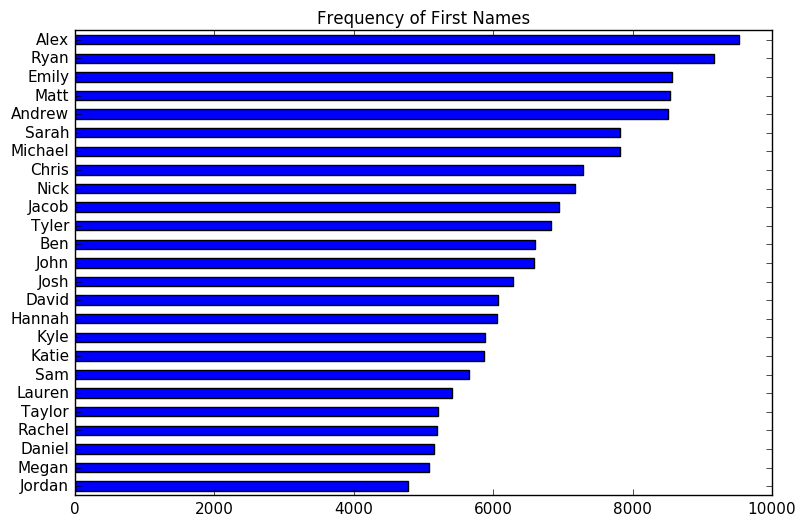

In [443]:
plt.figure(figsize=(9,6))
athlete_school.First_Name.value_counts().head(25).plot.barh(title = 'Frequency of First Names', fontsize = 11)
ax = plt.gca()
ax.invert_yaxis()
plt.show()

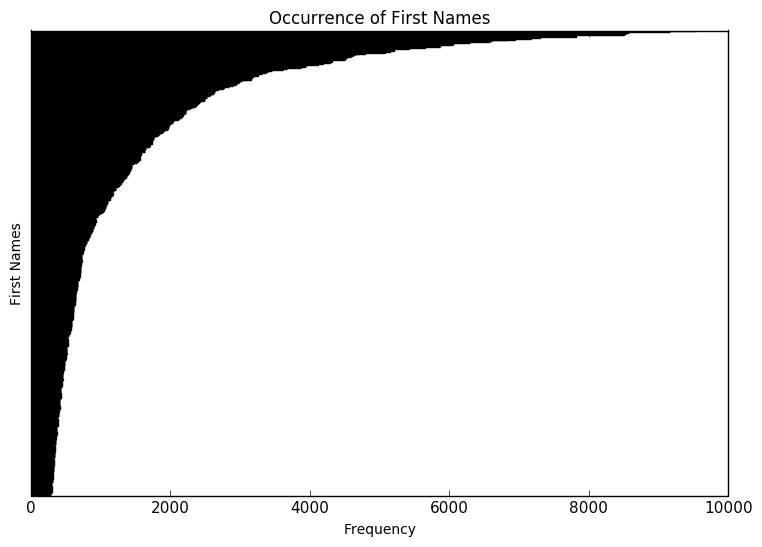

In [445]:
plt.figure(figsize=(9,6))
athlete_school.First_Name.value_counts().head(500).plot.barh(title = 'Frequency of First Names', fontsize = 11)
ax = plt.gca()
ax.invert_yaxis()
plt.yticks([])
plt.xlabel('Frequency')
plt.ylabel('First Names')
plt.title('Occurrence of First Names')
plt.show()

In [446]:
## Fastest boys times run since 2000
boys.sort_values('Time').head(10)

,Rank,Time,Athlete/School,Grade,Meet,Year,State,Gender
228735,1,850.4,Dathan Ritzenhein Rockford,2001,"MHSAA State Championships LP 1st Nov 4, 2000",2000,MI,Boys
321789,1,858.7,Edward Cheserek St. Benedict's Prep,2013,"Essex County Championships 1st Oct 26, 2012",2012,NJ,Boys
320789,1,860.0,Edward Cheserek St. Benedict's Prep,2013,"Essex County Championships 1st Oct 28, 2011",2011,NJ,Boys
484278,1,860.8,Andrew Hunter Loudoun Valley,2016,"Third Battle Invitational 1st Oct 17, 2015",2015,VA,Boys
45326,1,864.0,German Fernandez Riverbank High School (SJ),2008,CIF State Cross Country Championships 1st Nov...,2007,CA,Boys
22024,1,867.2,Bernie Montoya Cibola High School,2013,"Division 1 Section 1 1st Oct 26, 2012",2012,AZ,Boys
481261,1,868.0,Sean McGorty Chantilly,2013,"Foot Locker South Regional 1st Nov 24, 2012",2012,VA,Boys
496496,1,871.7,Tanner Anderson North Central High School,2015,"WIAA State Championship 1st Nov 8, 2014",2014,WA,Boys
446782,1,872.2,Brodey Hasty BrentwoodH High School,2018,Great American Cross Country Festival 1st Sep...,2016,TN,Boys
419126,1,872.4,David Principe Jr. La Salle Academy,2017,Great American Cross Country Festival 2nd Sep...,2016,RI,Boys


In [447]:
## Fastest girls times run since 2000
girls.sort_values('Time').head(10)

,Rank,Time,Athlete/School,Grade,Meet,Year,State,Gender
560641,1,984.1,Amber Trotter Ukiah High School (NC),2002,"Foot Locker Nationals 2001 1st Dec 8, 2001",2001,CA,Girls
821727,1,987.0,Ryen Frazier Unattached (NC),2015,"Foot Locker South Regional 1st Nov 29, 2014",2014,NC,Girls
916838,1,989.0,Weini Kelati Heritage (Leesburg),2016,"Third Battle Invitational 1st Oct 17, 2015",2015,VA,Girls
926262,1,991.1,Amy-Eloise Neale Glacier Peak High School,2013,"Sundodger Invitational 1st Sep 15, 2012",2012,WA,Girls
567478,1,992.0,Nikki Hiltz Aptos High School (CC),2013,CIF California Cross Country State Meet 106th...,2009,CA,Girls
573491,1,992.1,Fiona O'Keeffe Davis Senior High School (SJ),2016,"Stanford Invitational 1st Sep 26, 2015",2015,CA,Girls
927262,1,995.0,Alexa Efraimson Camas High School,2015,"Bill Dellinger Invitational 1st Oct 5, 2013",2013,WA,Girls
822728,1,996.1,Nevada Mareno Leesville Road,2017,"CAP 8 Conference Championship 1st Oct 20, 2015",2015,NC,Girls
538811,1,1000.0,Allie Ostrander Kenai Central High School,2015,"Palmer Invitational 1st Sep 6, 2014",2014,AK,Girls
572486,1,1000.0,Fiona O'Keeffe Davis Senior High School (SJ),2016,"Stanford Invitational 1st Sep 27, 2014",2014,CA,Girls


In [448]:
df.iloc[boys.Time.idxmin()]

Rank                                                          1
Time                                                      850.4
Athlete/School                      Dathan Ritzenhein  Rockford
Grade                                                      2001
Meet              MHSAA State Championships LP  1st Nov 4, 2000
Year                                                       2000
State                                                        MI
Gender                                                     Boys
Name: 228735, dtype: object

In [449]:
df.iloc[girls.Time.idxmin()]

Rank                                                        1
Time                                                    984.1
Athlete/School          Amber Trotter  Ukiah High School (NC)
Grade                                                    2002
Meet              Foot Locker Nationals 2001  1st Dec 8, 2001
Year                                                     2001
State                                                      CA
Gender                                                  Girls
Name: 560641, dtype: object

In [450]:
avg_5k = datetime.timedelta(seconds = df.Time.mean())
boys_avg_5k = datetime.timedelta(seconds = boys.Time.mean())
girls_avg_5k = datetime.timedelta(seconds = girls.Time.mean())

print 'Average 5K: ' + str(avg_5k)
print 'Boys Average 5K: ' +  str(boys_avg_5k)
print 'Girls Average 5K: ' + str(girls_avg_5k)

Average 5K: 0:20:18.947700
Boys Average 5K: 0:18:34.368611
Girls Average 5K: 0:22:29.312121


# Let's plot!

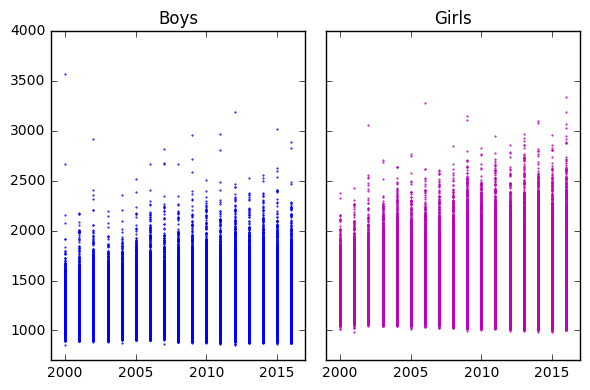

In [451]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
ax1.scatter(boys.Year, boys.Time, s = 1, marker = ".", color = 'b')
ax1.set_title('Boys')
ax1.set_xlim([1999, 2017])
ax1.set_ylim([700, 4000])
ax2.scatter(girls.Year, girls.Time, s = 1, marker = ".", color = 'm')
ax2.set_title('Girls')
ax2.set_xlim([1999, 2017])

plt.tight_layout()
plt.show()

# Completeness of the database

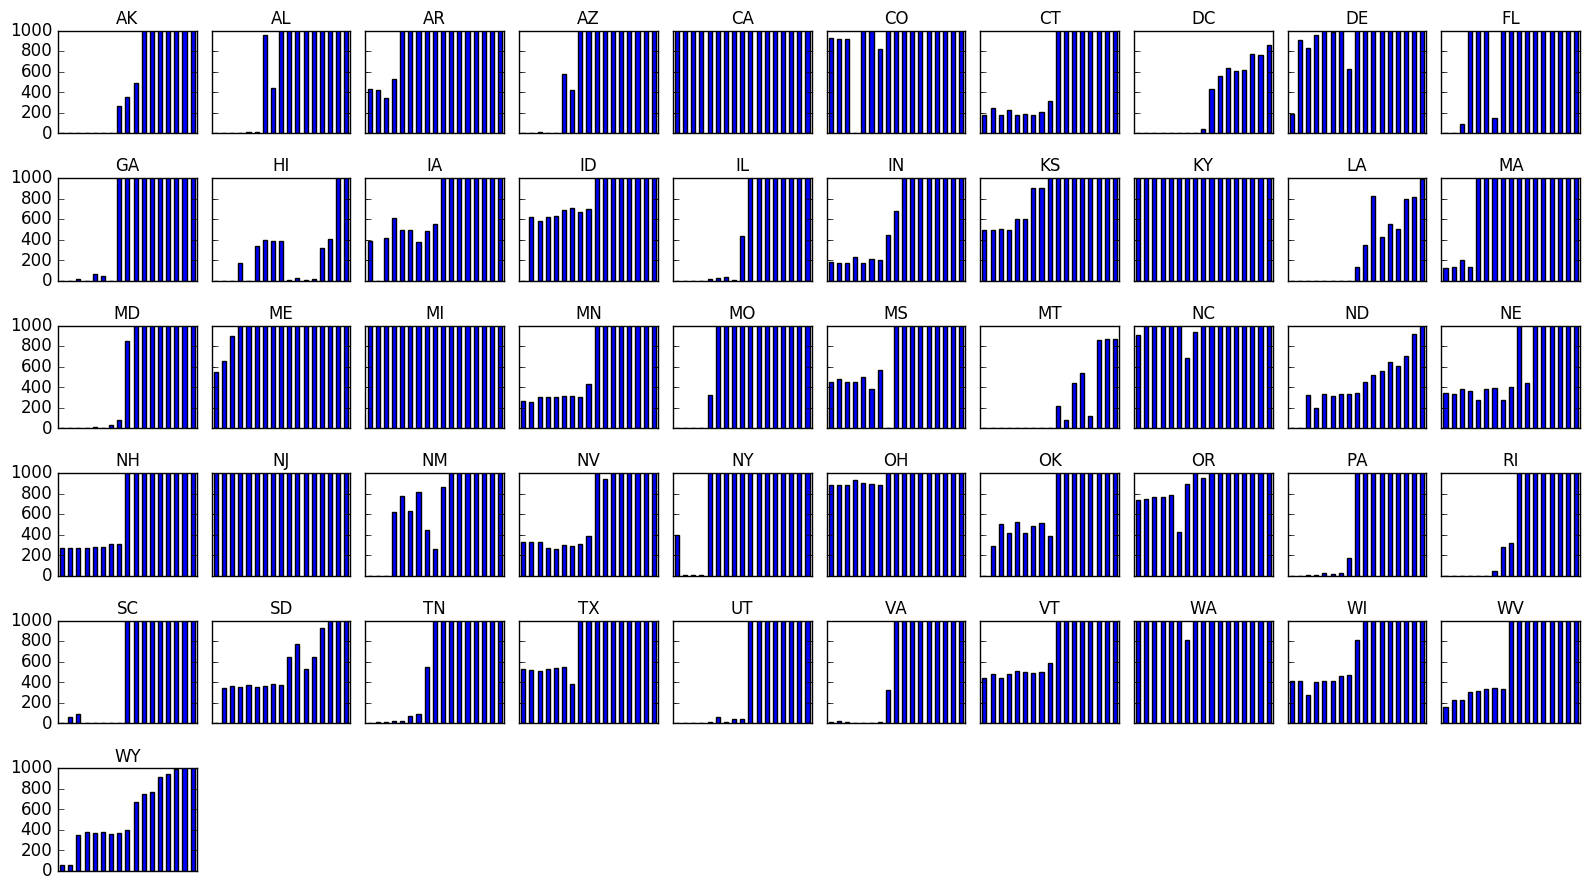

In [452]:
years = ['2000','2001','2002','2003','2004','2005','2006','2007',
         '2008','2009','2010','2011','2012','2013','2014','2015','2016']
years = map(int, years)

ind = 0
for key in sorted(df.Time.groupby(df.State).groups.keys()):    
    ind = ind + 1
    ax = plt.subplot(6, 10, ind)
    plt.axis([2000, 2016, 0, 1000])
    plt.xticks([])
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    df.Time.groupby([df.State, df.Year]).count().get(key).reindex(index=years).plot.bar(
        title = key, figsize = (16, 9), fontsize = 12, sharey = True, sharex = False) 
    plt.tight_layout()
    plt.xlabel('')
plt.show()

# Other fun stats

In [453]:
## State Record holding Boys (only online records, only dating back to 2000)
boys.sort_values('Time').groupby('State').head(1).sort_index()

,Rank,Time,Athlete/School,Grade,Meet,Year,State,Gender
5752,1,903.3,Mac Macoy Vestavia Hills HS,2014,"FSU Invitational (Pre-State) 2nd Oct 11, 2013...",2013,AL,Boys
12742,1,883.9,Levi Thomet Kodiak High School,2015,"George Fox Cross Country Classic 2nd Oct 12, ...",2013,AK,Boys
22024,1,867.2,Bernie Montoya Cibola High School,2013,"Division 1 Section 1 1st Oct 26, 2012",2012,AZ,Boys
35748,1,903.0,Jacob Shiohira Bentonville High School,2015,"Foot Locker South Regional 13th Nov 30, 2013",2013,AR,Boys
45326,1,864.0,German Fernandez Riverbank High School (SJ),2008,CIF State Cross Country Championships 1st Nov...,2007,CA,Boys
64183,1,886.5,Cerake Geberkidane Denver East High School,2014,Arvada West Cross Country Invitational 1st Se...,2013,CO,Boys
74935,1,887.0,Alex Ostberg Darien High School,2015,"FCIAC XC Championships 1st Oct 20, 2014",2014,CT,Boys
78661,1,916.5,Mike Crozier Gonzaga College High School,2012,Nike Cross Nationals Southeast Regional 4th N...,2011,DC,Boys
91211,1,906.8,Kevin Murray Charter School of Wilmington,2016,Nike Cross Nationals Southeast Regional 2nd N...,2015,DE,Boys
98158,1,891.0,Matt Mizereck Leon HS,2010,"Foot Locker South Regional 4th Nov 28, 2009",2009,FL,Boys


In [454]:
## State Record holding Girls (only online records, only dating back to 2000)
girls.sort_values('Time').groupby('State').head(1).sort_index()

,Rank,Time,Athlete/School,Grade,Meet,Year,State,Gender
533035,1,1017.0,Amaris Tyynismaa Catholic - Montgomery,2019,"Foot Locker South Regional 1st Nov 29, 2014",2014,AL,Girls
538811,1,1000.0,Allie Ostrander Kenai Central High School,2015,"Palmer Invitational 1st Sep 6, 2014",2014,AK,Girls
548202,1,1002.9,Danielle Jones Desert Vista High School,2015,"Desert Twilight XC Festival 2nd Oct 3, 2014",2014,AZ,Girls
554870,1,1054.0,Maggie Montoya Rogers High School,2013,Arkansas Chili Pepper Festival Invitational 1...,2011,AR,Girls
560641,1,984.1,Amber Trotter Ukiah High School (NC),2002,"Foot Locker Nationals 2001 1st Dec 8, 2001",2001,CA,Girls
587059,1,1004.0,Brie Oakley Grandview High School,2017,Liberty Bell Cross Country Invitational 1st S...,2016,CO,Girls
592236,1,1035.8,Hannah Debalsi Staples High School,2016,"New England XC Championship 1st Nov 9, 2013",2013,CT,Girls
597018,1,1042.0,Devoe Arnold St. Albans School,2014,"IAC, ISL, MAC Championships 5th Oct 26, 2013",2013,DC,Girls
602594,1,1013.0,Julie Macedo Charter School of Wilmington,2012,Six Flags Wild Safari Invitational - Girls 1s...,2011,DE,Girls
612582,1,1014.1,Kathryn Fluehr Community School of Naples,2011,"FHSAA 1A District 6 1st Nov 4, 2010",2010,FL,Girls


In [455]:
## quick glance at any given state
boys.groupby('State').get_group('CO').describe().drop('Grade', 1).round()
# girls.groupby('State').get_group('CO').describe().drop('Grade', 1).round()

,Rank,Time,Year
count,12868.0,12868.0,12868.0
mean,438.0,1079.0,2010.0
std,280.0,74.0,4.0
min,1.0,886.0,2000.0
25%,201.0,1036.0,2007.0
50%,401.0,1074.0,2010.0
75%,667.0,1107.0,2013.0
max,1000.0,1957.0,2016.0


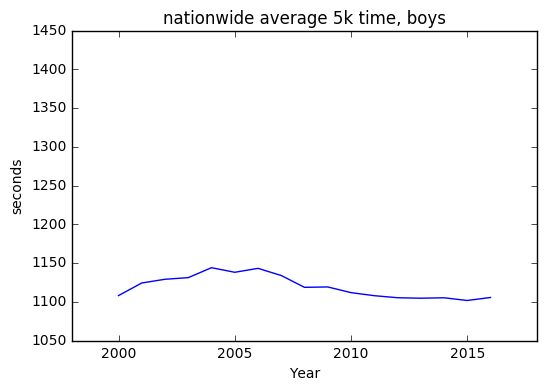

In [456]:
boys.Time.groupby(df.Year).mean().plot(color = 'b')
plt.axis([1998, 2018, 1050, 1450])
plt.ylabel('seconds')
plt.title('nationwide average 5k time, boys')
plt.show()

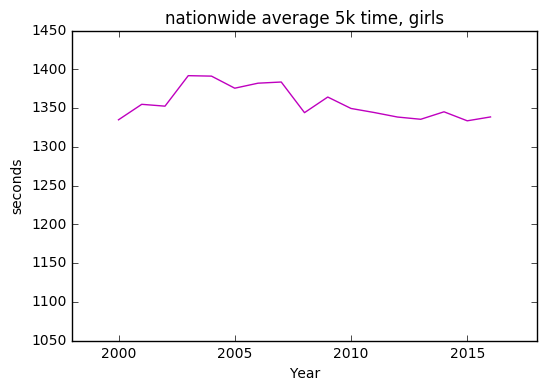

In [457]:
girls.Time.groupby(df.Year).mean().plot(color = 'm')
plt.axis([1998, 2018, 1050, 1450])
plt.ylabel('seconds')
plt.title('nationwide average 5k time, girls')
plt.show()

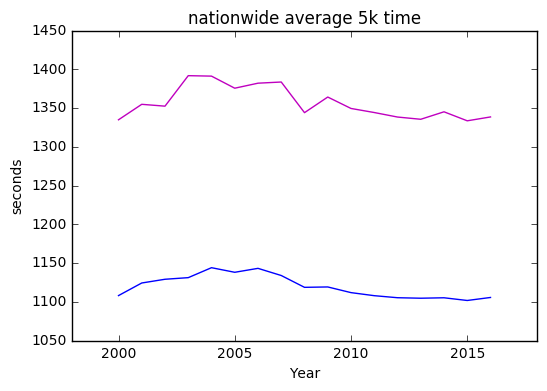

In [458]:
boys.Time.groupby(df.Year).mean().plot(color = 'b')
girls.Time.groupby(df.Year).mean().plot(color = 'm')
plt.axis([1998, 2018, 1050, 1450])
plt.ylabel('seconds')
plt.title('nationwide average 5k time')
plt.show()

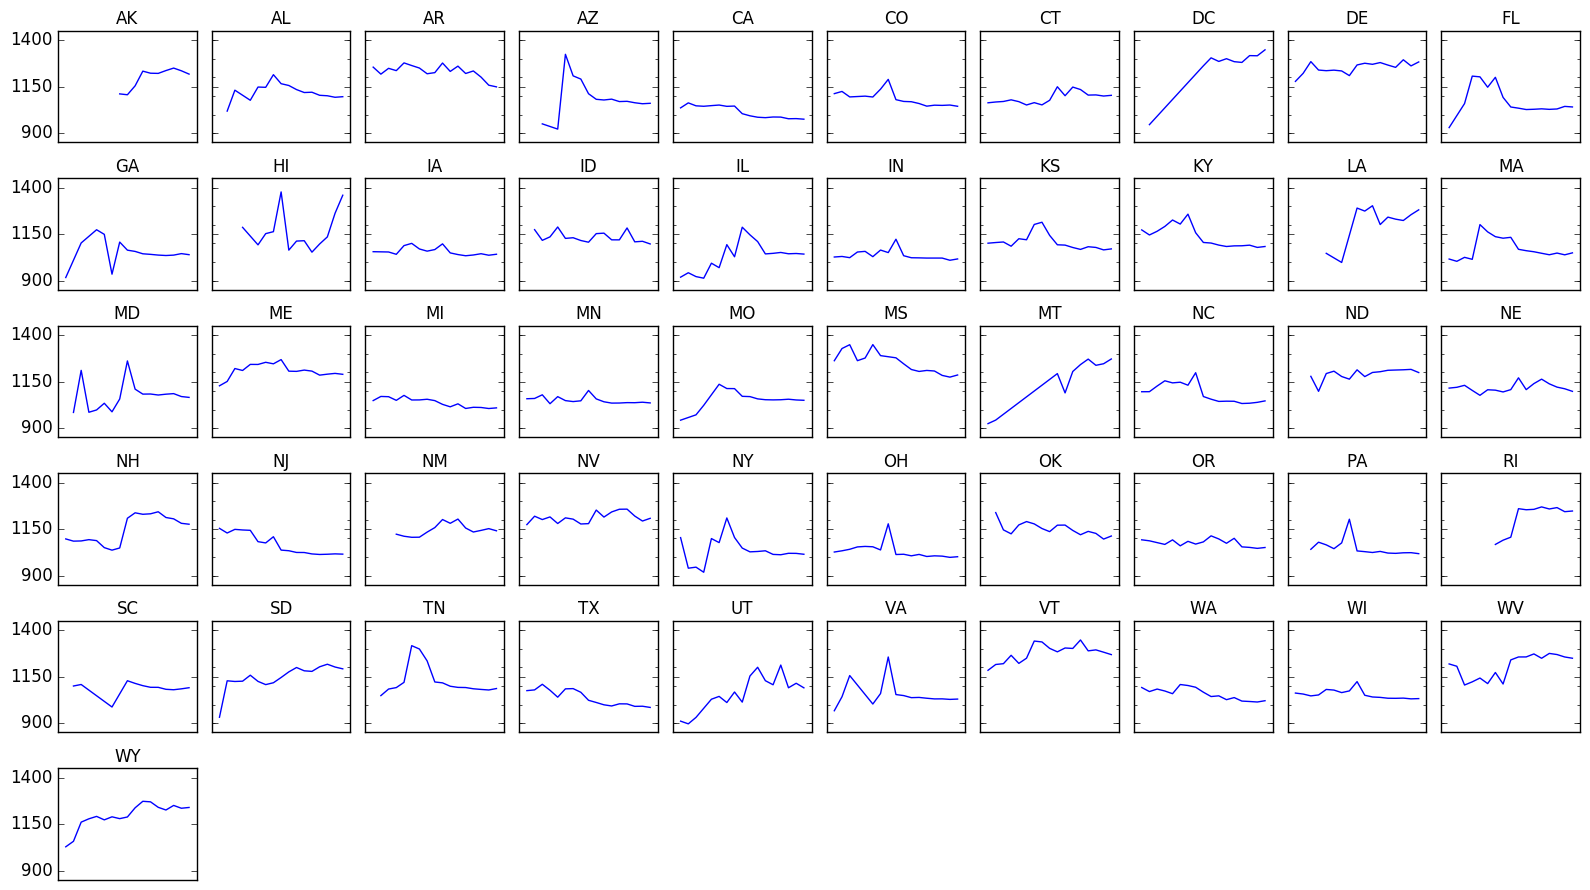

In [459]:
df2 = boys.Time.groupby([df.State, df.Year]).mean()

ind = 0
for key in sorted(df.Time.groupby(df.State).groups.keys()):    
    ind = ind + 1 
    plt.subplot(6, 10, ind)
    plt.xticks([])
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    df2[key].fillna(0).plot(title = key, figsize = (16, 9), yticks = [900, 1150, 1400],
                            color = 'b', fontsize = 12, sharey = True, sharex = False)
    plt.axis([1999, 2017, 850, 1450])
    plt.tight_layout()
    plt.xlabel('')
plt.show()

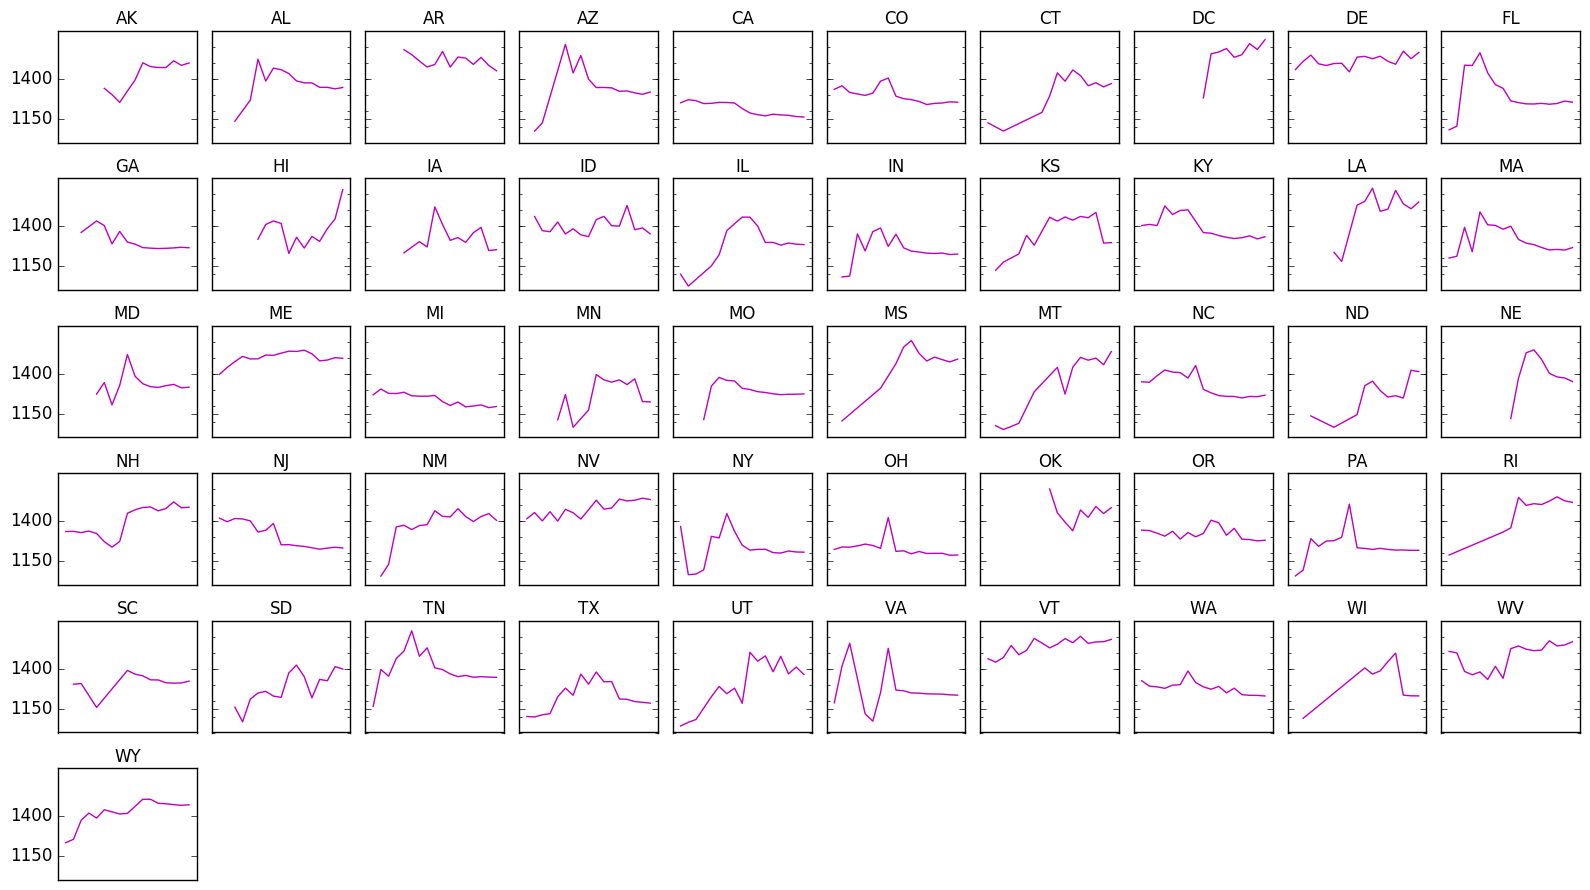

In [460]:
df3 = girls.Time.groupby([df.State, df.Year]).mean()

ind = 0
for key in sorted(df.Time.groupby(df.State).groups.keys()):    
    ind = ind + 1 
    plt.subplot(6, 10, ind)
    plt.xticks([])
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    df3[key].fillna(0).plot(title = key, figsize = (16, 9), yticks = [900, 1150, 1400],
                            color = 'm', fontsize = 12, sharey = True, sharex = False)
    plt.axis([1999, 2017, 1000, 1700])
    plt.tight_layout()
    plt.xlabel('')
plt.show()

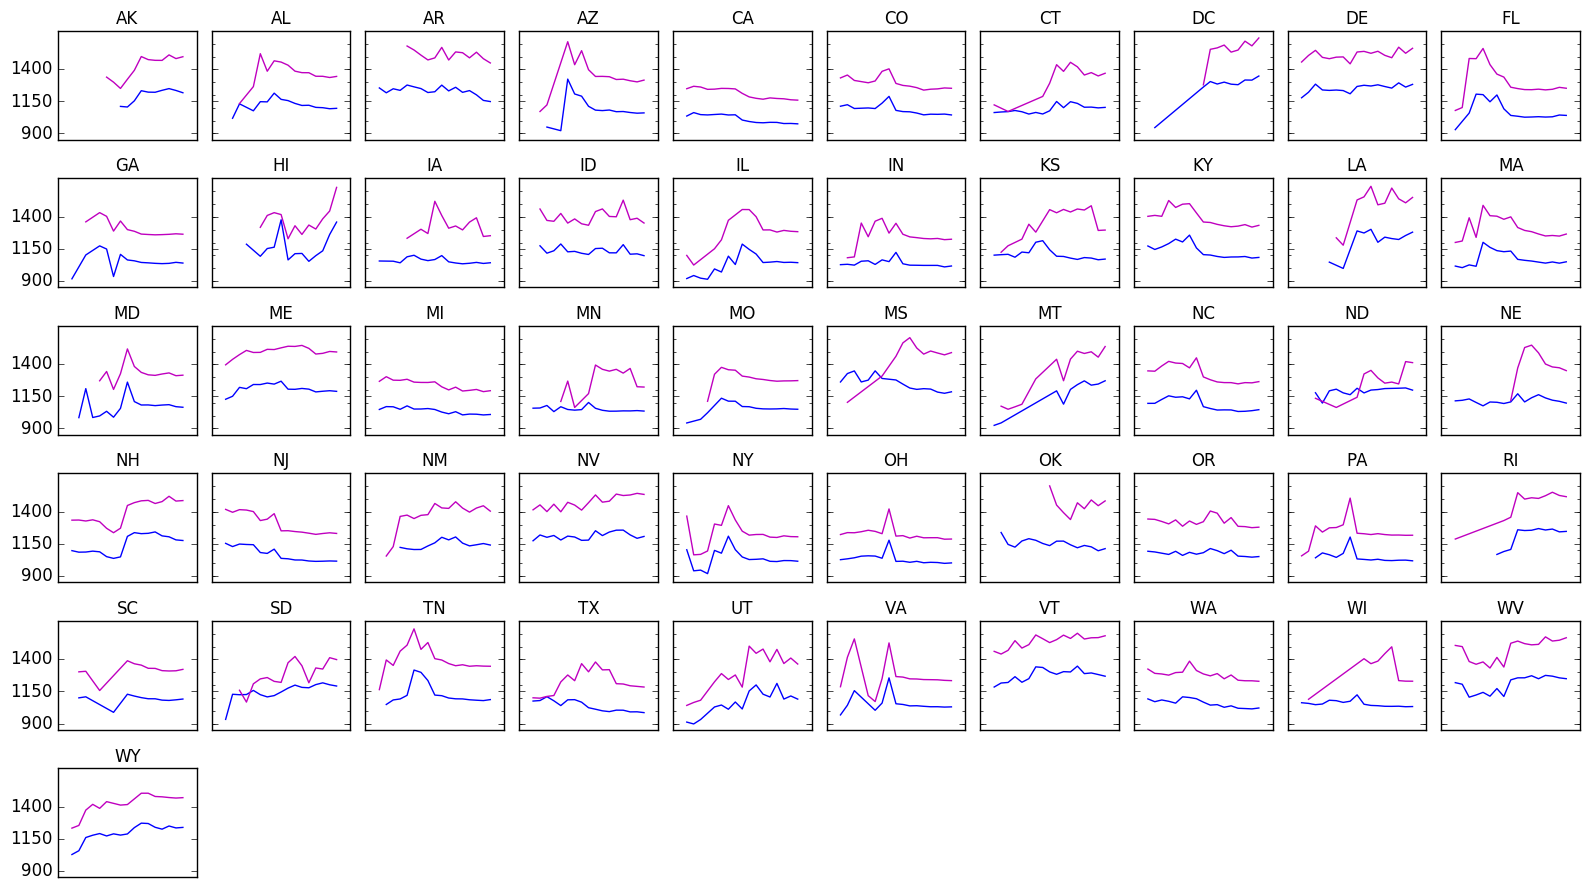

In [461]:
ind = 0
for key in sorted(df.Time.groupby(df.State).groups.keys()):    
    ind = ind + 1 
    plt.subplot(6, 10, ind)
    plt.xticks([])
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    df2[key].fillna(0).plot(title = key, figsize = (16, 9), yticks = [900, 1150, 1400],
                            color = 'b', fontsize = 12, sharey = True, sharex = False)
    df3[key].fillna(0).plot(title = key, figsize = (16, 9), yticks = [900, 1150, 1400],
                            color = 'm', fontsize = 12, sharey = True, sharex = False)
    plt.axis([1998, 2018, 850, 1700])
    plt.tight_layout()
    plt.xlabel('')
plt.show()

In [465]:
import plotly as py

py.offline.init_notebook_mode() # run at the start of every ipython notebook

dfplotly = pd.read_csv('d3usa5kboys.csv')

for col in dfplotly.columns:
    dfplotly[col] = dfplotly[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

# df['text'] = df['state'] + '<br>' +\
#     '2000 '+df['2000']+' 2001 '+df['2001']+'<br>'+\
#     '2002 '+df['2002']+' 2003 ' + df['2003']+'<br>'+\
#     '2004 '+df['2004']+' 2005 '+df['2005']

dfplotly['text'] = dfplotly['state']

data = [dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = dfplotly['code'],
        z = dfplotly['elevation'].astype(float),
        locationmode = 'USA-states',
        text = dfplotly['text'],
        marker = dict(
            line = dict(
                    color = 'rgb(255,255,255)',
                    width = 2)),
            colorbar = dict(
                    title = "Elevation (ft)"))]

layout = dict(
            title = 'US Elevation by State<br>(Hover for detail)',
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showlakes = False,
                lakecolor = 'rgb(255, 255, 255)'),)

fig = dict( data=data, layout=layout )
py.offline.iplot( fig, filename='plotly-elevation' )

In [523]:
year = ['2000','2001','2002','2003','2004','2005','2006','2007',
        '2008','2009','2010','2011','2012','2013','2014','2015','2016']

for yr in year:
  
    # df['text'] = df['state'] + '<br>' +\
    #     '2000 '+df['2000']+' 2001 '+df['2001']+'<br>'+\
    #     '2002 '+df['2002']+' 2003 ' + df['2003']+'<br>'+\
    #     '2004 '+df['2004']+' 2005 '+df['2005']

    data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = dfplotly['code'],
        z = dfplotly[yr].astype(float),
        locationmode = 'USA-states',
        text = dfplotly['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
            colorbar = dict(
            title = "% Difference",
        ))]

    layout = dict(
        title = 'Percent Difference from national average Boys 5K time by State<br><br>'+yr,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa'),
            showlakes = False))

    fig = dict(data=data, layout=layout)
#     py.offline.iplot(fig, filename='choropleth-map_' + yr, image = 'png')
    py.offline.iplot(fig, filename='choropleth-map_' + yr)